In [74]:
import numpy as np
from tqdm import tqdm
from glob import glob
from scipy.stats import norm
from scipy.special import erf
from matplotlib import pyplot as plt
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [75]:
pattern = "fakedata/*.txt*"

data_files = glob(pattern)

#random.shuffle(data_files)

tot_max = len(data_files)
boot_max = tot_max

Ntotdata = len(np.loadtxt(data_files[0], unpack=True))
# df = pd.read_csv(data_files[0], header=None, names=['Value'])
time_max = 100
num_samples = 10000

input = np.ndarray(shape = (tot_max, time_max))
output = np.ndarray(shape = (tot_max, num_samples))

#for ind,file in enumerate(data_files):
for ind in range(0,tot_max):
    #x_temp = np.loadtxt(file, unpack=True)
    x_temp = np.loadtxt(data_files[ind], unpack=True)
    input[ind] = x_temp[0:time_max]
    output[ind] = x_temp[Ntotdata-num_samples:]
    
    
num_train = boot_max - 1
num_test = boot_max - 1 # boot_max - 1

input_train = input[0:num_train,:]
input_test = input[num_test,:]


out_train = output[0:num_train,:]
out_test = output[num_test,:]

In [76]:
boot, time, corr = np.loadtxt("bootstrap/bootstrap1k_secondofile.dat", unpack=True)
#boot, time, corr = np.loadtxt("data/corr.txt", unpack=True)


time_max = int(np.max(time) + 1)
boot_max = int(np.max(boot))

#num_train = boot_max - 1
num_test = int(boot_max/2) #boot_max-1 #boot_max - num_train

input = np.ndarray(shape = (boot_max, time_max))
for ind, elem in enumerate(input):
    auxind = ind * time_max
    input[ind] = np.array([corr[ii + auxind] for ii in range(0,time_max)])

num_test = 0
#input_train = input[0:num_train,:]
input_test = input[num_test,:]
#print(input_test)
    
num_samples = 10000
x = np.linspace(0, 0.3, num_samples)
etaharm = 0.05
smear_sigma = 0.01

aux_zeta = 0.5 + 0.5 * erf(etaharm/np.sqrt(2)/smear_sigma)

pdf = 1./2.**0.5/aux_zeta*norm.pdf(x, loc = etaharm, scale = smear_sigma)

pdf2 = 1./2.**(3./2.)/aux_zeta*( norm.pdf(x, loc = etaharm, scale = smear_sigma) + 1./9.*norm.pdf(x, loc = 3*etaharm, scale = smear_sigma) )
##plt.plot(x, pdf)
##plt.show()

#out_train = np.ndarray(shape = (num_train, num_samples))
#for ii in range(0, num_train):
#    out_train[ii] = 1./2./np.sqrt(np.pi*smear_sigma)*pdf

In [77]:
# Define the Residual Block with Layer Normalization
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.norm1 = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.LayerNorm(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            )

    def forward(self, x):
        #print(x.shape, 'd1')
        out = self.conv1(x)
        #print(out.shape, 'd2')
        out = self.norm1(out.permute(0, 2, 1)).permute(0, 2, 1)  # Permute for layer normalization
        #print(out.shape, 'd')
        out = self.relu(out)
        out = self.conv2(out)
        #print(out.shape)
        out = self.norm2(out.permute(0, 2, 1)).permute(0, 2, 1)
        #print(out.shape)
        out += self.shortcut(x)
        #print(out.shape)
        out = self.relu(out)
        return out

# Define the CNN with Skip Connection, Dropout, and Layer Normalization
class SimpleCNNWithSkipDropoutNorm(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(SimpleCNNWithSkipDropoutNorm, self).__init__()
        # Convolutional layers with skip connection and layer normalization
        self.conv1 = ResidualBlock(1, 16)
        self.conv2 = ResidualBlock(16, 32)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(32 * input_size, 256)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(256, output_size)  # Assuming 10 classes for classification
        # Activation function and layer normalization
        self.relu = nn.ReLU()
        self.norm_fc = nn.LayerNorm(256)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape, 'afterRB1')
        x = self.conv2(x)
        #print(x.shape, 'afterRB2')
        #x = x.view(-1, 32 * 16 * 16)  # Reshape for fully connected layer
        x = x.reshape(1, 1, -1) #x.view(x.size(0), -1)
        x = self.relu(self.norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [78]:
learning_rate = 0.005
input_size = time_max
output_size = num_samples

In [80]:
loss_fun=nn.MSELoss()


rete=SimpleCNNWithSkipDropoutNorm(input_size, output_size)

losses = []
n_discr = int(num_train/1)
dstep = int((num_train-1)/n_discr + 1)

optimizer = torch.optim.Adam(rete.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(rete.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

for j in range(1):
    #for i in range(0,n_discr):
    for i in tqdm(range(n_discr), desc="Progress", ncols=100):
        #optimizer = torch.optim.Adam(rete.parameters(), lr=0.01)
        in_train = torch.tensor(input_train[i*dstep:(i+1)*dstep,:])
        in_train = in_train.float().unsqueeze(0)
        #print(in_train.shape)
        #in_train = in_train.squeeze()
        #input_train = input_train.reshape((dstep, len(phi_train[0,:])))
        #print(input_train)
        #p = torch.randn((100,2))*10
        target = torch.tensor(out_train[i*dstep:(i+1)*dstep,:])
        target = target.float()
        #target = target.squeeze()
        #target = target.unsqueeze(1)
        #target = torch.tensor([2.0])
        result=rete(in_train)
        #print(target.dtype)
        #print(result.dtype)
        #print(target, result)
        loss=loss_fun(target, result)
        losses.append(loss.item())
        optimizer.zero_grad()
        #for name, param in rete.named_parameters():
        #    print(f"Parameter name: {name}")
        #    print(f"Parameter value: {param}")
        #    print("-------------")
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #for name, param in rete.named_parameters():
        #    print(f"Parameter name: {name}")
        #    print(f"Parameter value: {param}")
        #    print("-------------")
        #sys.exit()
        #print(loss)
        #for p in rete.parameters():
        #    p.data.sub_(0.001*p.grad)

        #rete.zero_grad()

Progress: 100%|█████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.67it/s]


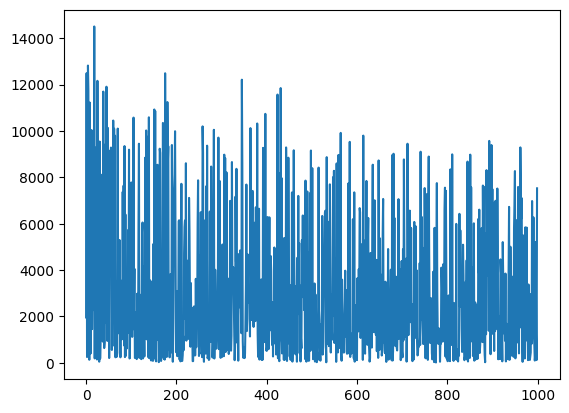

In [81]:
plt.plot(losses)

In [90]:
print(f"boot_max = {boot_max}")

mean_out_test = torch.tensor(np.zeros(len(out_test)))
err_out_test = torch.tensor(np.zeros(len(out_test)))

#n_discr = num_test
#dstep = int((num_test-1)/n_discr + 1)
#boot_max = 4
for test_num in range(boot_max):
    #input_train = input[0:num_train,:]
    input_test = input[test_num,:]
    in_test = torch.tensor(input_test)
    in_test = in_test.float().unsqueeze(0).unsqueeze(0)
    #print(in_test.shape)

    rete.eval()

    with torch.no_grad():
        out_net = rete(in_test)
        
    out_net = out_net.squeeze()

    mean_out_test += out_net
    err_out_test += torch.square(out_net)


mean_out_test = mean_out_test / float(boot_max)
err_out_test = torch.sqrt((err_out_test- float(boot_max)*torch.square(mean_out_test))/ (float(boot_max)-1.))
#out_net = distribNTKgp(input_test, input_train, out_train, eta, n_layer, sigma_w, sigma_b, n0)

print(err_out_test)

boot_max = 1000
tensor([0.0017, 0.0017, 0.0017,  ..., 0.0028, 0.0028, 0.0028],
       dtype=torch.float64)


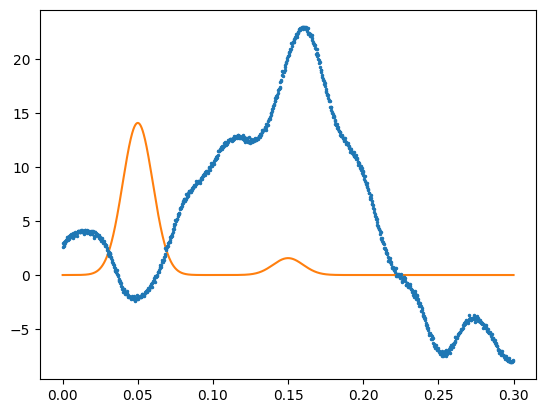

In [91]:
#xjj, yjj = np.loadtxt("data/spectrum_smeared1.txt", unpack="True")

#print(out_net, len(input_test))
#plt.xlim(0,0.3)
selected_indices = np.arange(0, len(x), 10)
selected_x = x[selected_indices]
selected_mean = mean_out_test[selected_indices]
selected_errors = err_out_test[selected_indices]

#plt.plot(x, out_net)
#plt.plot(x, mean_out_test)
plt.errorbar(selected_x, selected_mean, yerr=selected_errors, fmt='.', markersize=3, capsize=1, elinewidth=1)
#plt.xlim([0,10])
plt.plot(x, pdf2)
#plt.plot(xjj, yjj)#out_test)
plt.show()

In [24]:
# Load CIFAR-10 dataset
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Instantiate the model with skip connection, dropout, and layer normalization
cnn_model_with_skip_dropout_norm = SimpleCNNWithSkipDropoutNorm()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_with_skip_dropout_norm.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model_with_skip_dropout_norm(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics every 1000 batches
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

100%|██████████| 170498071/170498071 [00:08<00:00, 20455608.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


TypeError: SimpleCNNWithSkipDropoutNorm.__init__() missing 2 required positional arguments: 'input_size' and 'output_size'

In [ ]:
# Define a sample input (assuming 3 channels and 32x32 image size)
sample_input = torch.randn((1, 3, 32, 32))

# Forward pass
output = cnn_model_with_skip_dropout_norm(sample_input)
print("Model output shape with skip connection:", output.shape)